In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Normal:


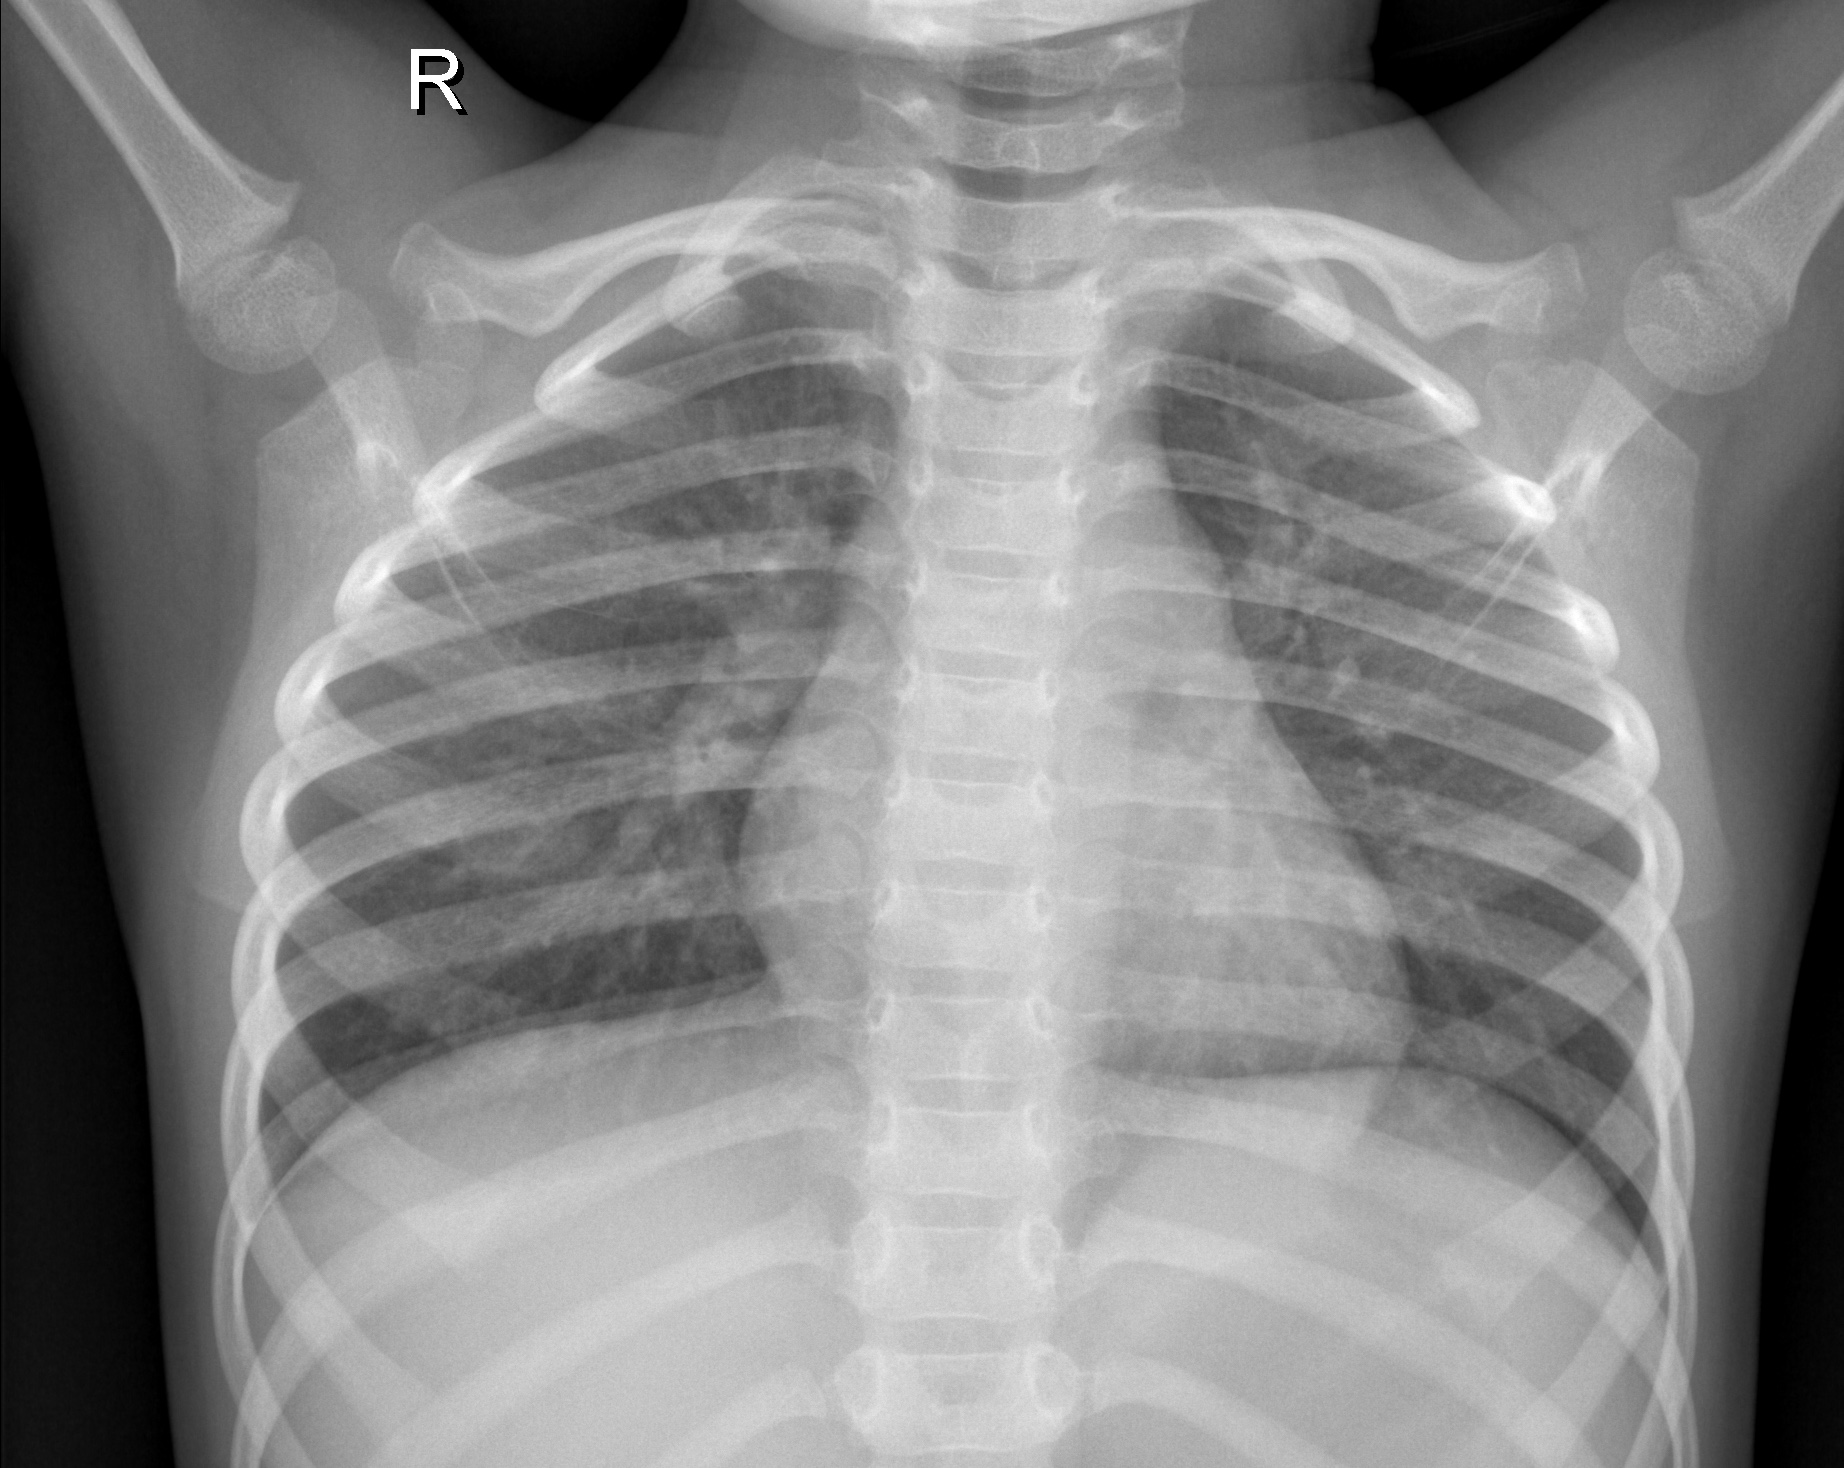

Pneumonitis :


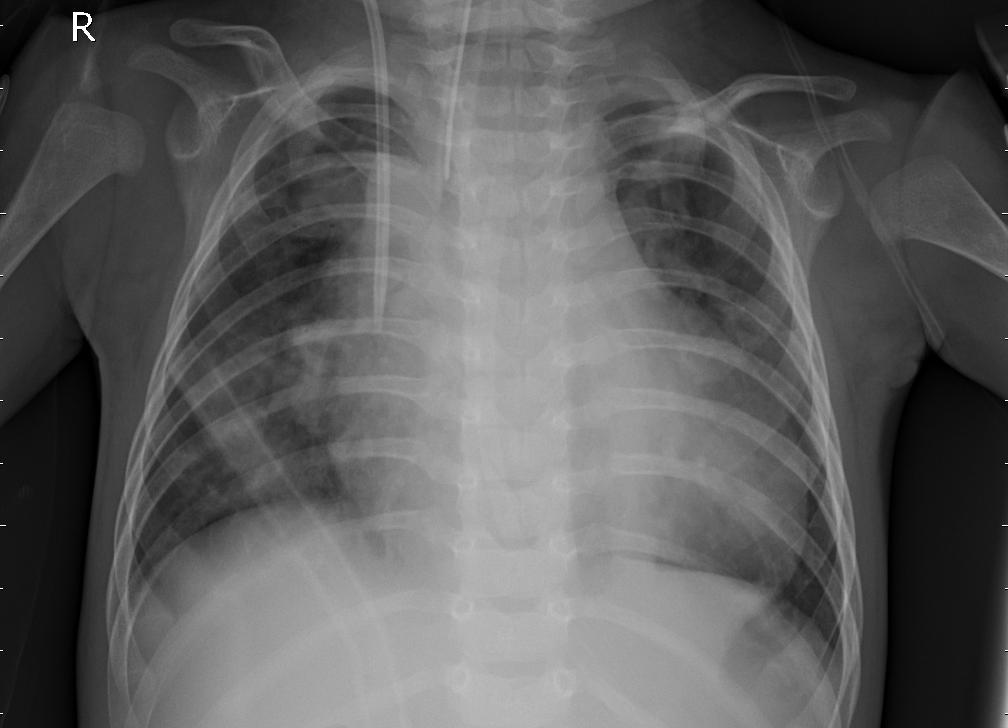

In [ ]:
# Make sure the images are there
from IPython.display import Image, display
print("Normal:")
display(Image(filename='/content/gdrive/MyDrive/chest_xray_new/train/NORMAL/IM-0242-0001.jpeg', width = 300))
print("Pneumonitis :")
display(Image(filename='/content/gdrive/MyDrive/chest_xray_new_again/train/PNEUMONIA/person1028_bacteria_2959.jpeg', width = 300))

In [ ]:
# Download and import libraries
!pip install torch torchvision 
#matplotlib numpy scikit-image pillow==4.1.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! pip install matplotlib numpy 
#scikit-image pillow==4.1.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! pip install pillow==4.1.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.3 MB 21.8 MB/s 
     |████████████████████████████████| 112 kB 65.1 MB/s 
  Created wheel for pillow: filename=Pillow-4.1.1-cp37-cp37m-linux_x86_64.whl size=1009892 sha256=57cd619dd9349559eddbe2d1c0840d93917b775839437ae04283071c5f118a4f
  Stored in directory: /root/.cache/pip/wheels/51/53/67/d76ff9fd54dd89a25efce20d2e7c9b35348db386b53deb8095
  Created wheel for olefile: filename=olefile-0.46-py2.py3-none-any.whl size=35433 sha256=c37a6dc8740fca2575c62b9f93f39b8d83e317fd71dac6b1798a918573e8b7a2
  Stored in directory: /root/.cache/pip/wheels/84/53/e6/37d90ccb3ad1a3ca98d2b17107e9fda401a7c541ea1eb6a65a
Successfully built pillow olefile
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
ERROR: pip's dependency resolver does not currently take into acco

In [ ]:
! pip install scikit-image 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.2 MB 31.0 MB/s 
  Attempting uninstall: pillow
    Found existing installation: Pillow 4.1.1
    Uninstalling Pillow-4.1.1:
      Successfully uninstalled Pillow-4.1.1


In [ ]:
# For plotting
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# For conversion
from skimage.color import lab2rgb, rgb2lab, rgb2gray
from skimage import io
# For everything
import torch
import torch.nn as nn
import torch.nn.functional as F
# For our model
import torchvision.models as models
from torchvision import datasets, transforms
# For utilities
import os, shutil, time

In [ ]:
use_gpu=torch.cuda.is_available()

In [ ]:
# Check if GPU is available
use_gpu = torch.cuda.is_available()

In [ ]:
class ColorizationNet(nn.Module):
  def __init__(self, input_size=128):
    super(ColorizationNet, self).__init__()
    MIDLEVEL_FEATURE_SIZE = 128

    ## First half: ResNet
    resnet = models.resnet34(num_classes=365) 
    # Change first conv layer to accept single-channel (grayscale) input
    resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
    # Extract midlevel features from ResNet-gray
    self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])

    ## Second half: Upsampling
    self.upsample = nn.Sequential(     
      nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
      nn.Upsample(scale_factor=2)
    )

  def forward(self, input):

    # Pass input through ResNet-gray to extract features
    midlevel_features = self.midlevel_resnet(input)

    # Upsample to get colors
    output = self.upsample(midlevel_features)
    return output

In [ ]:
model = ColorizationNet()

In [ ]:
criterion = nn.MSELoss()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=0.0)

In [ ]:
class GrayscaleImageFolder(datasets.ImageFolder):
  '''Custom images folder, which converts images to grayscale before loading'''
  def __getitem__(self, index):
    path, target = self.imgs[index]
    img = self.loader(path)
    if self.transform is not None:
      img_original = self.transform(img)
      img_original = np.asarray(img_original)
      img_lab = rgb2lab(img_original)
      img_lab = (img_lab + 128) / 255
      img_ab = img_lab[:, :, 1:3]
      img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()
      img_original = rgb2gray(img_original)
      img_original = torch.from_numpy(img_original).unsqueeze(0).float()
    if self.target_transform is not None:
      target = self.target_transform(target)
    return img_original, img_ab, target

In [ ]:
# Training
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip()])
train_imagefolder_normal = GrayscaleImageFolder('/content/gdrive/MyDrive/chest_xray_new_again/train', train_transforms)
train_loader_normal = torch.utils.data.DataLoader(train_imagefolder_normal, batch_size=64, shuffle=True)

# Validation 
val_transforms = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224)])
val_imagefolder_normal = GrayscaleImageFolder('/content/gdrive/MyDrive/chest_xray_new_again/val' , val_transforms)
val_loader_normal = torch.utils.data.DataLoader(val_imagefolder_normal, batch_size=64, shuffle=False)

In [ ]:
train_imagefolder_normal

Dataset GrayscaleImageFolder
    Number of datapoints: 400
    Root location: /content/gdrive/MyDrive/chest_xray_new_again/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               RandomHorizontalFlip(p=0.5)
           )

In [ ]:
len(val_loader_normal)

2

In [ ]:
class AverageMeter(object):
  '''A handy class from the PyTorch ImageNet tutorial''' 
  def __init__(self):
    self.reset()
  def reset(self):
    self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

def to_rgb(grayscale_input, ab_input, save_path=None, save_name=None):
  '''Show/save rgb image from grayscale and ab channels
     Input save_path in the form {'grayscale': '/path/', 'colorized': '/path/'}'''
  plt.clf() # clear matplotlib 
  color_image = torch.cat((grayscale_input, ab_input), 0).numpy() # combine channels
  color_image = color_image.transpose((1, 2, 0))  # rescale for matplotlib
  color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
  color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128   
  color_image = lab2rgb(color_image.astype(np.float64))
  grayscale_input = grayscale_input.squeeze().numpy()
  if save_path is not None and save_name is not None: 
    plt.imsave(arr=grayscale_input, fname='{}{}'.format(save_path['grayscale'], save_name), cmap='gray')
    plt.imsave(arr=color_image, fname='{}{}'.format(save_path['colorized'], save_name))

In [ ]:
def validate(val_loader, model, criterion, save_images, epoch, validate_losses):
  model.eval()

  # Prepare value counters and timers
  batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

  end = time.time()
  already_saved_images = False
  for i, (input_gray, input_ab, target) in enumerate(val_loader):
    data_time.update(time.time() - end)

    # Use GPU
    if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

    # Run model and record loss
    output_ab = model(input_gray) # throw away class predictions
    loss = criterion(output_ab, input_ab)
    losses.update(loss.item(), input_gray.size(0))
    validate_losses.append(loss.item())

    # Save images to file
    if save_images and not already_saved_images:
      already_saved_images = True
      for j in range(min(len(output_ab), 10)): # save at most 5 images
        save_path = {'grayscale': 'outputs/gray/', 'colorized': 'outputs/color/'}
        save_name = 'img-{}-epoch-{}.jpg'.format(i * val_loader.batch_size + j, epoch)
        to_rgb(input_gray[j].cpu(), ab_input=output_ab[j].detach().cpu(), save_path=save_path, save_name=save_name)

    # Record time to do forward passes and save images
    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to both value and validation
    if i % 25 == 0:
      print('Validate: [{0}/{1}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
             i, len(val_loader), batch_time=batch_time, loss=losses))

  print('Finished validation.')
  return losses.avg, validate_losses

In [ ]:
def train(train_loader, model, criterion, optimizer, epoch, train_losses):
  print('Starting training epoch {}'.format(epoch))
  model.train()
  
  # Prepare value counters and timers
  batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

  end = time.time()
  for i, (input_gray, input_ab, target) in enumerate(train_loader):
    
    # Use GPU if available
    if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

    # Record time to load data (above)
    data_time.update(time.time() - end)

    # Run forward pass
    output_ab = model(input_gray) 
    loss = criterion(output_ab, input_ab) 
    losses.update(loss.item(), input_gray.size(0))
    train_losses.append(loss.item())

    # Compute gradient and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Record time to do forward and backward passes
    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to value, not validation
    if i % 25 == 0:
      print('Epoch: [{0}][{1}/{2}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
              epoch, i, len(train_loader), batch_time=batch_time,
             data_time=data_time, loss=losses)) 

  print('Finished training epoch {}'.format(epoch))

In [ ]:
# Move model and loss function to GPU
if use_gpu: 
  criterion = criterion.cuda()
  model = model.cuda()

In [ ]:
# Make folders and set parameters
os.makedirs('outputs/color', exist_ok=True)
os.makedirs('outputs/gray', exist_ok=True)
os.makedirs('checkpoints', exist_ok=True)
save_images = True
best_losses = 1e10
epochs = 15

In [ ]:
len(train_loader_normal)

7

In [ ]:
# Train model
for epoch in range(epochs):
  # Train for one epoch, then validate
  train_losses = []
  train(train_loader_normal, model, criterion, optimizer, epoch, train_losses)
  with torch.no_grad():
    validate_losses = []
    losses_normal, validate_losses = validate(val_loader_normal, model, criterion, save_images, epoch, validate_losses)
  # Save checkpoint and replace old best model if current model is better
  if losses_normal < best_losses:
    best_losses = losses_normal
    torch.save(model.state_dict(), 'checkpoints/model-epoch-{}-losses-{:.3f}.pth'.format(epoch+1,losses_normal))

Starting training epoch 0
Epoch: [0][0/7]	Time 13.796 (13.796)	Data 6.868 (6.868)	Loss 0.2513 (0.2513)	
Finished training epoch 0


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 49724 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Validate: [0/2]	Time 42.519 (42.519)	Loss 2790091776.0000 (2790091776.0000)	
Finished validation.
Starting training epoch 1
Epoch: [1][0/7]	Time 1.816 (1.816)	Data 1.705 (1.705)	Loss 0.0239 (0.0239)	
Finished training epoch 1


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 29433 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 5058 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 34616 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 26287 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 21568 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: User

Validate: [0/2]	Time 3.056 (3.056)	Loss 4800.0093 (4800.0093)	
Finished validation.
Starting training epoch 2
Epoch: [2][0/7]	Time 1.895 (1.895)	Data 1.785 (1.785)	Loss 0.0127 (0.0127)	
Finished training epoch 2


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 10132 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 26618 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 2120 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 8852 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 85 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarn

Validate: [0/2]	Time 2.202 (2.202)	Loss 14.3342 (14.3342)	
Finished validation.
Starting training epoch 3
Epoch: [3][0/7]	Time 1.912 (1.912)	Data 1.803 (1.803)	Loss 0.0065 (0.0065)	
Finished training epoch 3
Validate: [0/2]	Time 2.123 (2.123)	Loss 0.0456 (0.0456)	
Finished validation.
Starting training epoch 4
Epoch: [4][0/7]	Time 1.932 (1.932)	Data 1.818 (1.818)	Loss 0.0034 (0.0034)	
Finished training epoch 4
Validate: [0/2]	Time 2.913 (2.913)	Loss 0.0021 (0.0021)	
Finished validation.
Starting training epoch 5
Epoch: [5][0/7]	Time 1.856 (1.856)	Data 1.740 (1.740)	Loss 0.0136 (0.0136)	
Finished training epoch 5


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 266 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 1728 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 434 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 118 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 3427 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning

Validate: [0/2]	Time 2.125 (2.125)	Loss 0.1592 (0.1592)	
Finished validation.
Starting training epoch 6
Epoch: [6][0/7]	Time 1.864 (1.864)	Data 1.751 (1.751)	Loss 0.0010 (0.0010)	
Finished training epoch 6


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 32 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 33 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Validate: [0/2]	Time 2.166 (2.166)	Loss 0.3335 (0.3335)	
Finished validation.
Starting training epoch 7
Epoch: [7][0/7]	Time 1.894 (1.894)	Data 1.774 (1.774)	Loss 0.0118 (0.0118)	
Finished training epoch 7


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 6 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 15 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Validate: [0/2]	Time 2.284 (2.284)	Loss 0.1316 (0.1316)	
Finished validation.
Starting training epoch 8
Epoch: [8][0/7]	Time 1.798 (1.798)	Data 1.687 (1.687)	Loss 0.0045 (0.0045)	
Finished training epoch 8
Validate: [0/2]	Time 2.204 (2.204)	Loss 0.0039 (0.0039)	
Finished validation.
Starting training epoch 9
Epoch: [9][0/7]	Time 1.882 (1.882)	Data 1.772 (1.772)	Loss 0.0012 (0.0012)	
Finished training epoch 9
Validate: [0/2]	Time 2.150 (2.150)	Loss 0.0027 (0.0027)	
Finished validation.
Starting training epoch 10
Epoch: [10][0/7]	Time 1.788 (1.788)	Data 1.678 (1.678)	Loss 0.0013 (0.0013)	
Finished training epoch 10
Validate: [0/2]	Time 2.158 (2.158)	Loss 0.0020 (0.0020)	
Finished validation.
Starting training epoch 11
Epoch: [11][0/7]	Time 1.997 (1.997)	Data 1.886 (1.886)	Loss 0.0006 (0.0006)	
Finished training epoch 11
Validate: [0/2]	Time 2.137 (2.137)	Loss 0.0015 (0.0015)	
Finished validation.
Starting training epoch 12
Epoch: [12][0/7]	Time 1.774 (1.774)	Data 1.662 (1.662)	Loss 0.000

<Figure size 432x288 with 0 Axes>

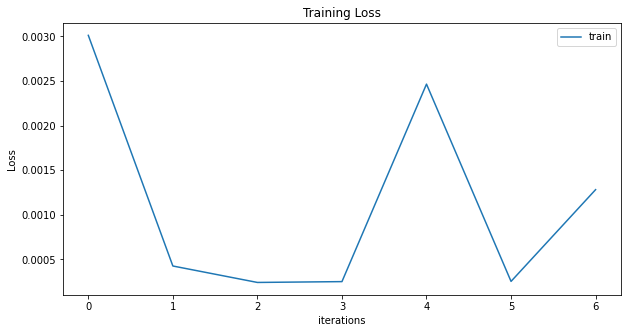

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()

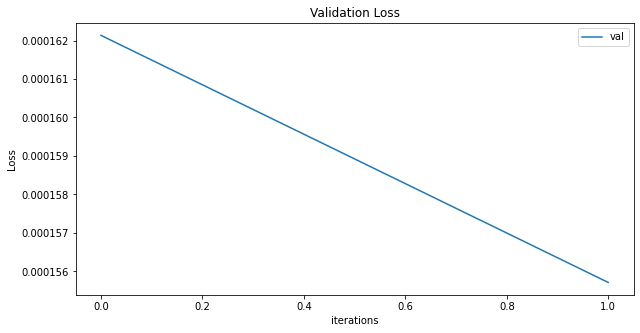

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Validation Loss")
plt.plot(validate_losses,label="val")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()

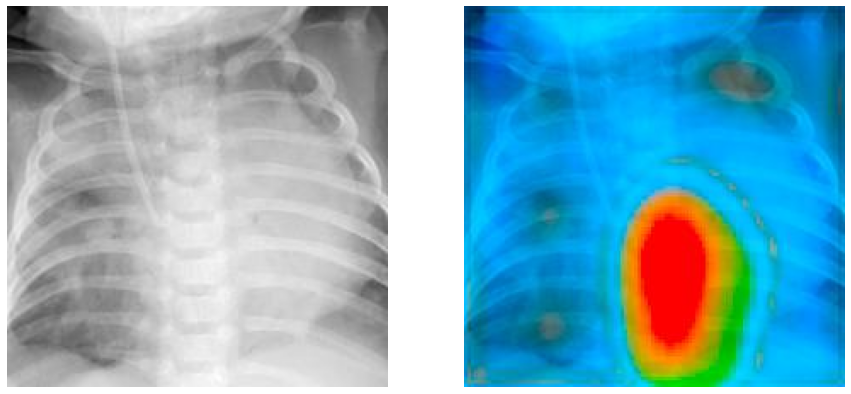

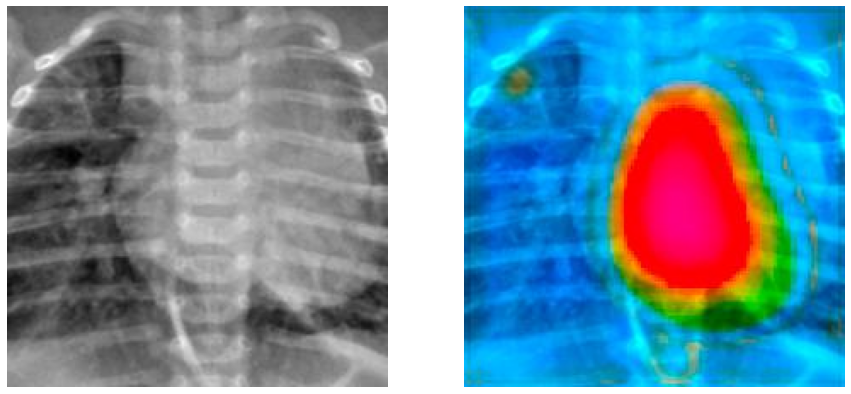

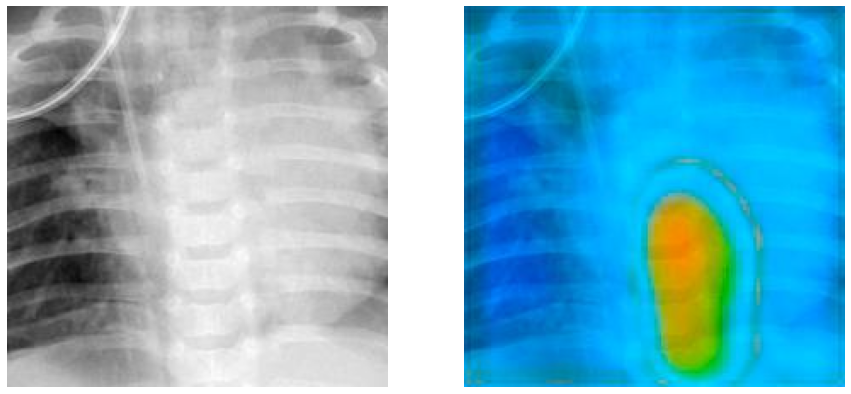

In [ ]:
# Show images 
import matplotlib.image as mpimg
image_pairs = [
               ('/content/outputs/color/img-6-epoch-2.jpg', '/content/outputs/gray/img-6-epoch-2.jpg'),
               ('/content/outputs/color/img-0-epoch-2.jpg', '/content/outputs/gray/img-0-epoch-2.jpg'),
                ('/content/outputs/color/img-3-epoch-2.jpg', '/content/outputs/gray/img-3-epoch-2.jpg')
               ]
for c, g in image_pairs:
  color = mpimg.imread(c)
  gray  = mpimg.imread(g)
  f, axarr = plt.subplots(1, 2)
  f.set_size_inches(15, 15)
  axarr[0].imshow(gray, cmap='gray')
  axarr[1].imshow(color)
  axarr[0].axis('off'), axarr[1].axis('off')
  plt.show()